In [1]:
import sys ; sys.path.append('../')
from load import RIR
from acoustic_params import Acoustic_params
from filterbank import Filterbank
from scipy import stats
from tqdm import tqdm
import librosa
import scipy
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from augmentation import *

In [2]:
rir_path = '/mnt/datasets/impulsos/reales/C4DM'
rir_list = get_audio_list(rir_path)

# Valores a generar

In [4]:
#TRs a generar 
TR_MIN = 0.1
TR_MAX = 1.25
TR_PASO = 0.05#0.05
trs = []
tr = TR_MIN
while tr < TR_MAX:
    trs.append(np.round(tr,2))
    tr = tr + TR_PASO

#DRRs a generar
DRR_MIN = -10
DRR_MAX = 10
DRR_PASO = 1
drrs = []
drr = DRR_MIN
while drr < DRR_MAX:
    drrs.append(drr)
    drr = drr + DRR_PASO
print('Tiempos de reverb: ', trs)
print('Relaciones directo-reverberado: ',drrs)

Tiempos de reverb:  [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2]
Relaciones directo-reverberado:  [-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [5]:
len(trs)*len(drrs)

460

In [7]:
parametros = []
for tr in trs:
    for drr in drrs:
        parametros.append([tr, drr])

# Aumentacion

In [8]:
c = 0
for (tr_deseado, drr_deseado) in tqdm(parametros):
    random_path = np.random.choice(rir_list)
    rir, fs = librosa.load(random_path, sr=16000)
    try:
        rir_aug_tr = tr_augmentation(rir, fs, tr_deseado)
        rir_aug_drr = drr_aug(rir_aug_tr, fs, drr_deseado)
    except:
        continue
    filename = 'rir_aug_primeraprueba/tr_{:.2f}_drr_{:.1f}_num_{:04d}.wav'.format(tr_deseado, drr_deseado,c)
    sf.write(filename, rir_aug_drr, 16000)
    c +=1

100%|██████████| 460/460 [08:06<00:00,  1.06s/it]


# Resultados

In [9]:
params = {'fs' : 16000,
      'bands' : [125, 250, 500, 1000, 2000, 4000],
      'bandsize' : 1,
      'order' : 4,
      'f_length': 16384,'power' : True}
filterbank = Filterbank(**params)

from tr_mid import t60_impulse_array

def impulse_info(array, fs):
    """Calcula el TRmid (promedio entre bandas de 500 y 1000 Hz) y la relacion
    directo reverberado para una respuesta al impulso 
    """
    #Tiempo de reverberacion
    tr_mid = t60_impulse_array(array, fs).mean()

    #Relacion directo-reverberado
    DRR = get_DRR(array, fs)
    
    return tr_mid, DRR

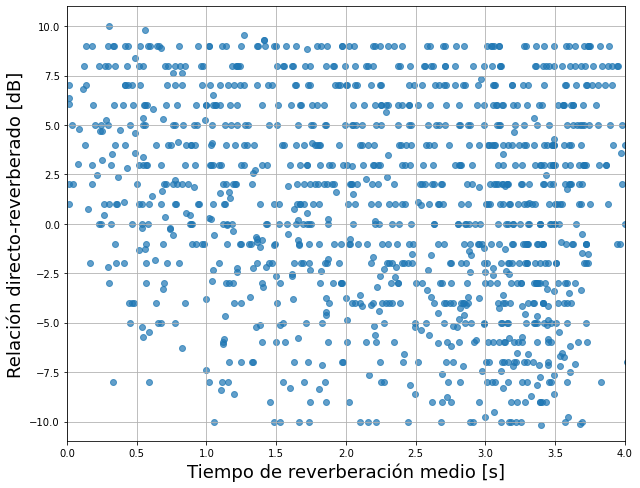

In [17]:
rir_path = 'rir_aug_database/'
rir_list = get_audio_list(rir_path)

tr_list=[]
drr_list=[]

for impulso in rir_list:
    rir, fs = librosa.load(impulso, sr=16000)
    tr, drr = impulse_info(rir, 16000)
    tr_list.append(tr)
    drr_list.append(drr)    
plt.figure(1, figsize = (10,8))
plt.scatter(tr_list, drr_list, alpha = 0.7, marker = 'o')
#plt.title('Respuestas al impulso reales aumentadas', fontsize=18)
plt.xlabel("Tiempo de reverberación medio [s]", fontsize=18)
plt.ylabel("Relación directo-reverberado [dB]", fontsize=18)
plt.xlim(0,4)
plt.ylim(-11, 11)
plt.savefig('cl_impulsos.png')
plt.grid()
plt.show()

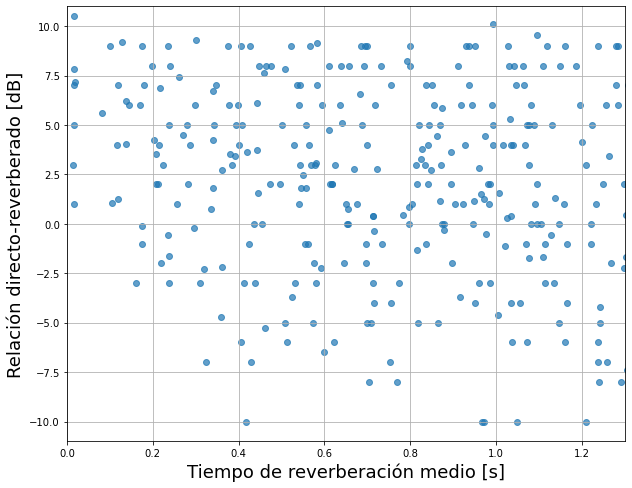

In [14]:
rir_path = 'rir_aug_primeraprueba/'
rir_list = get_audio_list(rir_path)

tr_list=[]
drr_list=[]

for impulso in rir_list:
    rir, fs = librosa.load(impulso, sr=16000)
    tr, drr = impulse_info(rir, 16000)
    tr_list.append(tr)
    drr_list.append(drr)    
plt.figure(1, figsize = (10,8))
plt.scatter(tr_list, drr_list, alpha = 0.7, marker = 'o')
#plt.title('Respuestas al impulso reales aumentadas', fontsize=18)
plt.xlabel("Tiempo de reverberación medio [s]", fontsize=18)
plt.ylabel("Relación directo-reverberado [dB]", fontsize=18)
plt.xlim(0,1.3)
plt.ylim(-11, 11)
plt.savefig('aumentadas.png')
plt.grid()
plt.show()

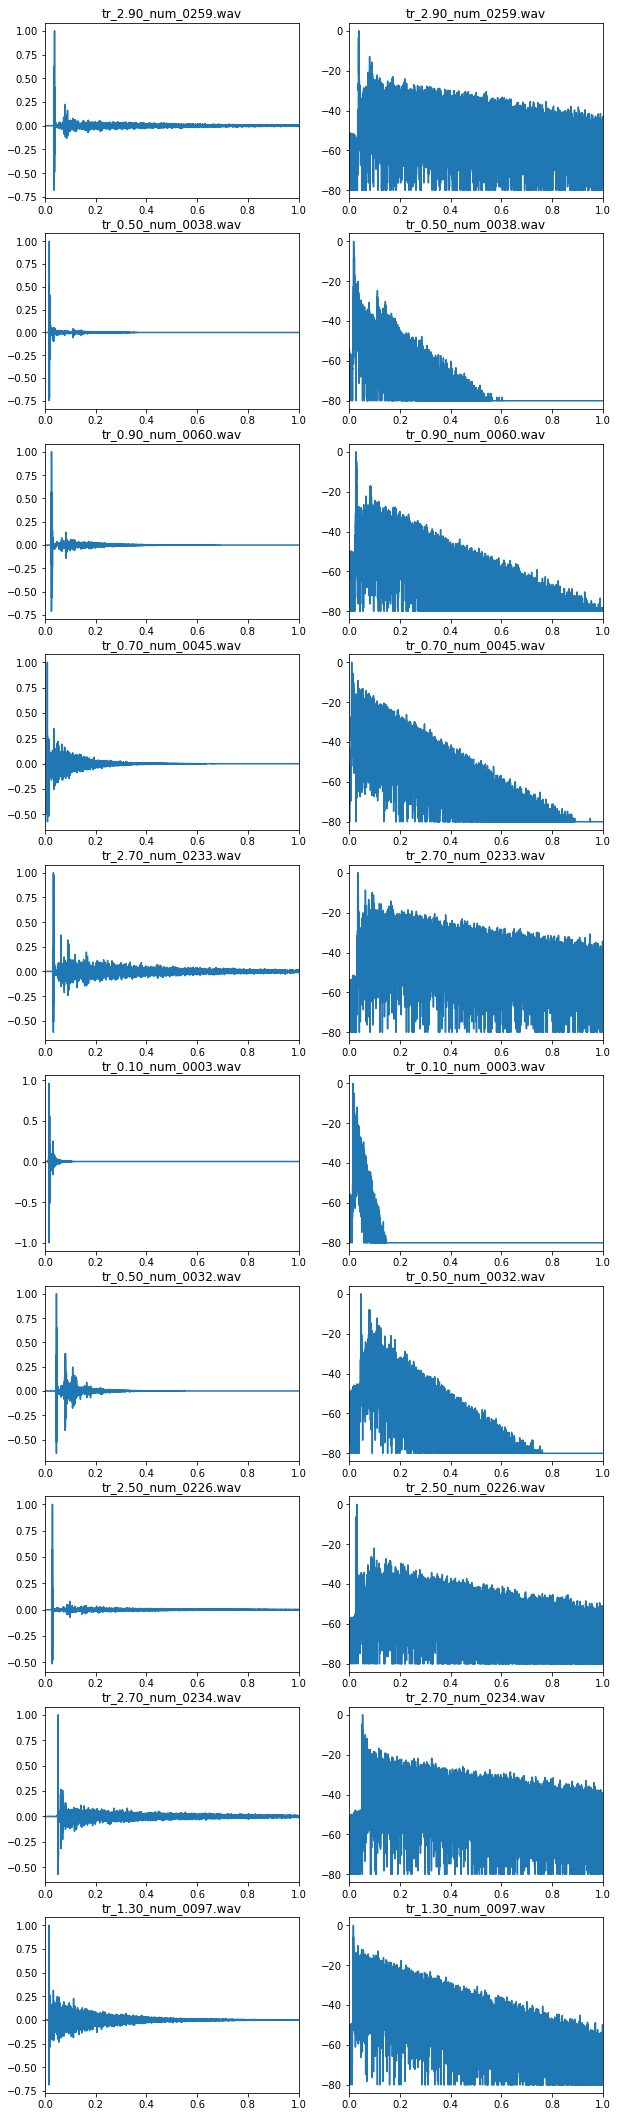

In [23]:
#ploteo algunos impulsos 
rirs_array = []
for path in rir_list:
    rir, fs = librosa.load(path, sr=16000)
    rirs_array.append(rir)

fig, axes = plt.subplots(10,2,figsize=(10,10))
t = np.linspace(0, len(rirs_array[0])/fs, len(rirs_array[0]))

for i, j in enumerate(np.random.randint(0,len(rir_list)-1,size=(10,))):
    axes[i,0].set_title(rir_list[j].split('/')[-1])
    axes[i,0].plot(t,rirs_array[j])
    axes[i,0].set_xlim(0,1)
    
    axes[i,1].set_title(rir_list[j].split('/')[-1])
    axes[i,1].plot(t,librosa.amplitude_to_db(rirs_array[j]))
    axes[i,1].set_xlim(0,1)
    #plot_tr(rir_list[j], axes[i, 2])

plt.subplots_adjust(top=3)